In [5]:
import psycopg2
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline 
import pylab
pylab.rcParams['figure.figsize'] = (10, 5)
import os
MIMIC_PW = os.environ['PGPASSWORD'] 

conn = psycopg2.connect(database='mimic', 
        user='mimic', password=MIMIC_PW,
        host='grinder.inf.ethz.ch', port=5432)
cur = conn.cursor()

## Split by subject_id and hadm_id (unique patient and unique patient hospital stay)

In [6]:
# SUBJECT_ID is unique to a patient and HADM_ID is unique to a patient hospital stay
cur.execute('''
    select distinct subject_id, hadm_id                                
    into temp sid_hid_note from noteevents;''')

# take the intersection of 2 tables (diagnoses_icd and noteevent), 
# keeping only the sid_hid pair that are in BOTH tables, and those with non-empty icd codes
cur.execute('''
    select diagnoses_icd.* 
    into temp t_diagnoses
    from diagnoses_icd inner join sid_hid_note 
    on diagnoses_icd.subject_id=sid_hid_note.subject_id and diagnoses_icd.hadm_id = sid_hid_note.hadm_id
    where char_length(icd9_code)>0
    order by subject_id, hadm_id, seq_num;''')
# the result is stored in the temp table `t_diagnoses`

cur.execute('''
    select distinct subject_id, hadm_id
    into temp intersection_sid_hid
    from t_diagnoses''')

cur.execute('''
    select noteevents.*
    into temp t_noteevents
    from intersection_sid_hid inner join noteevents
    on intersection_sid_hid.subject_id=noteevents.subject_id and intersection_sid_hid.hadm_id = noteevents.hadm_id
    order by subject_id, hadm_id''')

To skip the inspections, go to [section II](#II.-Collect-notes-into-csv-files)

## I. Inspections of data

###  How many distinct (patient,stay) pairs ? How many distinct diag codes ? How many diags/notes ?

In [7]:
cur.execute('''
    select count(distinct icd9_code)
    from t_diagnoses;''')
N_UNIQUE_DIAG = cur.fetchone()[0]
cur.execute(' select count(*) from intersection_sid_hid;')
N_DIAGS = cur.fetchone()[0]
cur.execute('select count(distinct (subject_id, hadm_id)) from t_diagnoses;')
N_SID_HID = cur.fetchone()[0]
cur.execute('select count(*) from t_noteevents;')
N_NOTES = cur.fetchone()[0]

print '%d (patient,stay) pairs, %d distinct diagnoses, %d diags and %d notes in total' % \
        (N_SID_HID, N_UNIQUE_DIAG, N_DIAGS, N_NOTES)

58328 (patient,stay) pairs, 6967 distinct diagnoses, 58328 diags and 1846769 notes in total


###  How many notes a patient (ie. sid_hid pair) has?

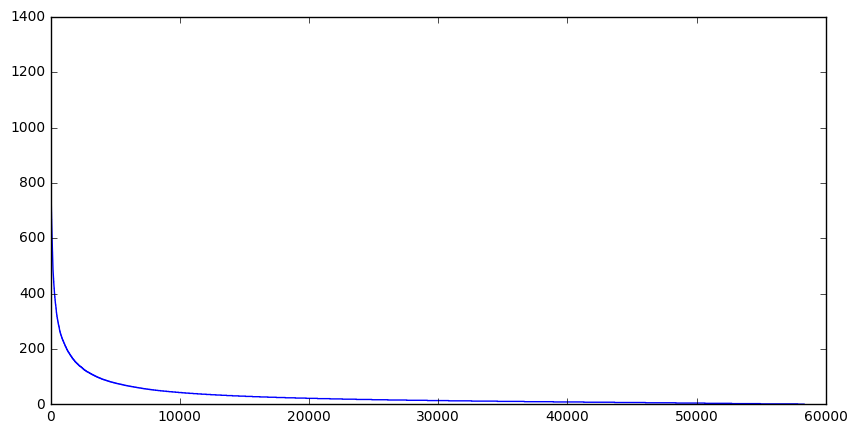

In [8]:
cur.execute('''
    select subject_id, hadm_id, count(*) as cnt
    from t_noteevents
    group by subject_id, hadm_id
    order by cnt desc''')
sid, hid, cnt = zip(*cur.fetchall())

# most of the patient has ~10 diagnoses codes
plt.plot(cnt)

In [9]:
# the outliers (ie. sid_hid with many notes)
zip( sid[:10], hid[:10], cnt[:10] )

[(30202, 117448, 1233L),
 (77614, 140792, 1144L),
 (78076, 138363, 1099L),
 (27427, 175448, 1084L),
 (6975, 192431, 1073L),
 (3014, 126258, 1010L),
 (15204, 168396, 983L),
 (12578, 172706, 969L),
 (862, 186550, 959L),
 (12613, 168201, 949L)]

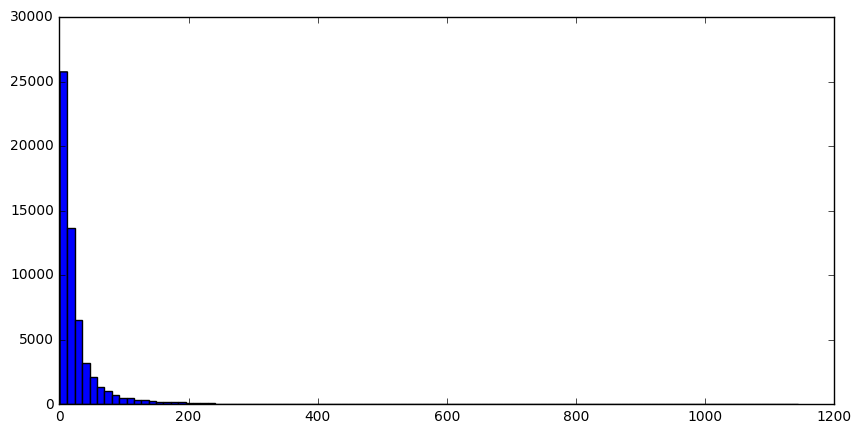

In [10]:
# most patient stays have <200 notes
_ = plt.hist(cnt[1:], bins = 100)

###  How many (distinct) diagnoses a patient (ie. sid_hid pair) has?

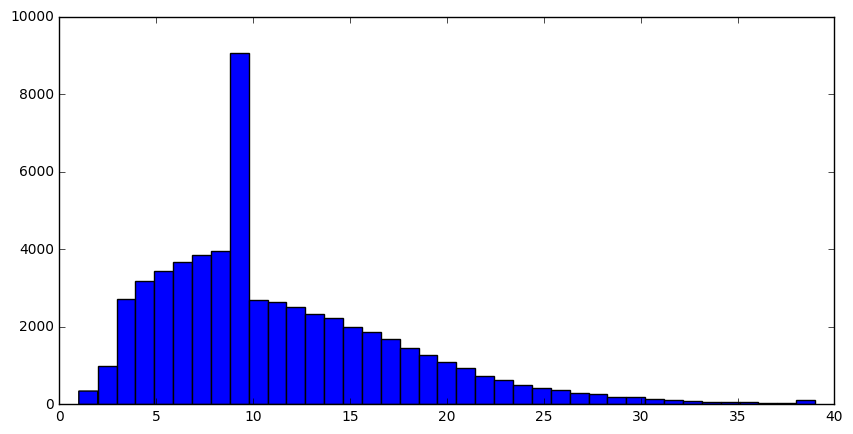

In [11]:
cur.execute('''
    select subject_id, hadm_id, count(distinct icd9_code) as cnt
    from t_diagnoses
    group by subject_id, hadm_id
    order by cnt desc''')
sid, hid, cnt = zip(*cur.fetchall())

# most of the patient has ~10 diagnoses codes
# plt.plot(cnt)
_ = plt.hist(cnt, bins=max(cnt))

### How many rows do the top100/top50 most freq codes cover?

top 100 freq diag codes covers 542.330% rows, top 50 covers 412.822%


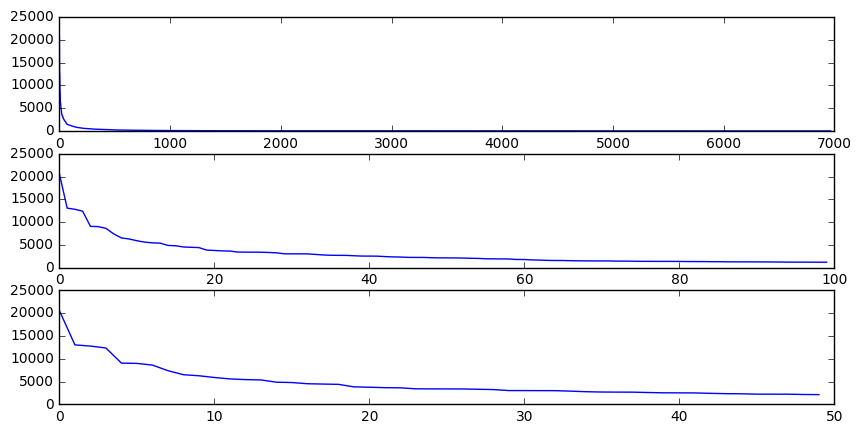

In [12]:
# What is the distribution of the unique diag codes ? 
# -- how many rows do the top100/top50 most freq codes cover?
cur.execute('''
    select icd9_code, count(*) as cnt
    from t_diagnoses
    group by icd9_code 
    order by cnt desc;''')

diag_icd, cnt = zip( *cur.fetchall() )
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharey=True)
ax1.plot(cnt)
ax2.plot(cnt[:100])
ax3.plot(cnt[:50])

ratio100, ratio50 = sum(cnt[:100]) *100.0 / N_DIAGS, sum(cnt[:50]) *100.0 / N_DIAGS
print 'top 100 freq diag codes covers %.3f%% rows, top 50 covers %.3f%%' % (ratio100, ratio50)

### How many patient stays (ie. sid,hid pair) can top100/top50 most freq codes cover ? 

In [13]:
# first write the icds of each sid_hid pair into a txt file
cur.execute('''
    select subject_id, hadm_id, string_agg(distinct icd9_code, ' ') as diag_icds
    from t_diagnoses
    group by subject_id, hadm_id
    order by subject_id, hadm_id;''')
with open('data/sid_hid_diagicds.txt', 'w') as f:
    for sid, hid, icds in tqdm(cur, total=N_SID_HID):
        f.write( '%s , %s, ' %(str(sid), str(hid))  + icds + '\n' )

cur.execute('''
    select icd9_code, count(distinct subject_id) as cnt
    from t_diagnoses
    group by icd9_code
    order by cnt desc;''')
diag_icds, cnt = zip(*cur.fetchall())
print zip( diag_icds[:10], cnt[:10] )

for topn in [50, 100, 200]:
    n_covered = 0
    top_icds = set( diag_icds[:topn] )
    with open('data/sid_hid_diagicds.txt') as f:
        for line in f:
            icds = set(line.split()[1:])
            if len(icds & top_icds)>0:
                n_covered += 1 
    print '%d out of %d patients are covered by top %3d icds, coverage=%.4f %%' % \
                (n_covered, N_SID_HID, topn, n_covered*100.0/N_SID_HID)

100%|██████████| 58328/58328 [00:00<00:00, 650792.76it/s]


[('4019', 17500L), ('41401', 10733L), ('42731', 10193L), ('4280', 9802L), ('5849', 7634L), ('2724', 7414L), ('25000', 7327L), ('51881', 6632L), ('5990', 5746L), ('V053', 5597L)]
54469 out of 58328 patients are covered by top  50 icds, coverage=93.3840 %
55849 out of 58328 patients are covered by top 100 icds, coverage=95.7499 %
57026 out of 58328 patients are covered by top 200 icds, coverage=97.7678 %


## II. Collect notes into csv files

In [15]:
import os
import pandas as pd
NOTES_DIR = '/local/XW/DATA/MIMIC/noteevents_by_sid_hid/'
if not os.path.exists(NOTES_DIR): 
    os.makedirs(NOTES_DIR)
# !rm $NOTES_DIR/*

In [16]:
CSV_HEADER = 'subject_id,hadm_id,chartdate,charttime,storetime,category,description,cgid,iserror,text'

cur.execute('''
    select %s
    from t_noteevents
    order by subject_id,hadm_id;''' % CSV_HEADER)

_current_sid = -1
_current_hid = -1
_buffer = []

def write_note_to_csv(fname, diry=NOTES_DIR, header=CSV_HEADER.split(',')):
    if len(_buffer)==0: return
    fname = os.path.join(diry,fname)
    df = pd.DataFrame(_buffer, columns=header)
    df.to_csv(fname, index=False, header=True)

In [17]:
for line in tqdm(cur, total=N_NOTES):
    sid,hid = line[:2]
    if sid != _current_sid or hid != _current_hid:
        write_note_to_csv("%d_%d.csv" % (_current_sid, _current_hid))
        _current_sid = sid
        _current_hid = hid
        _buffer = []    
    _buffer.append(line)

write_note_to_csv("%d_%d.csv" % (_current_sid, _current_hid))

100%|██████████| 1846769/1846769 [02:08<00:00, 14423.65it/s]


In [18]:
cur.close()